In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

batch_size = 64
trainset = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
straight_digits = [1, 4, 7]

def get_aux_labels(label):
  if label in straight_digits:
    return 1
  else:
    return 0

class CustomMNIST(Dataset):
  def __init__(self, mnist_dataset):
    self.mnist_dataset = mnist_dataset

  def __len__(self):
    return len(self.mnist_dataset)

  def __getitem__(self, idx):
    image, origin_label = self.mnist_dataset[idx]
    aux_label = get_aux_labels(origin_label)
    return image, (origin_label, aux_label)

In [ ]:
custom_dataset = CustomMNIST(trainset)

for i in range(3):
    image, (original_label, aux_label) = custom_dataset[i]
    print(f'Mẫu {i}: Nhãn gốc = {original_label}, Nhãn phụ = {aux_label}')

Mẫu 0: Nhãn gốc = 5, Nhãn phụ = 0
Mẫu 1: Nhãn gốc = 0, Nhãn phụ = 0
Mẫu 2: Nhãn gốc = 4, Nhãn phụ = 1


In [ ]:
custom_trainset = CustomMNIST(trainset)
custom_trainloader = DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

custom_testset = CustomMNIST(testset)
custom_testloader = DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
trainset[1][0].shape

torch.Size([1, 32, 32])

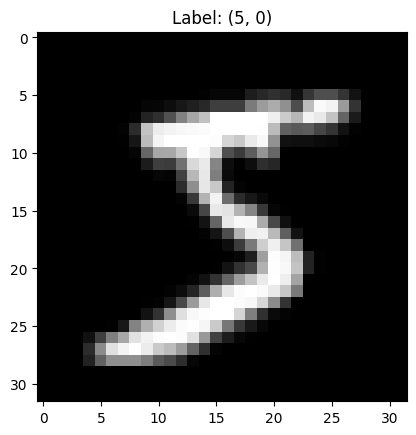

torch.Size([32, 32])


In [ ]:
image, (original_label, aux_label) = custom_trainset[0]

image = image.squeeze()

plt.imshow(image, cmap='gray')
plt.title(f"Label: {original_label, aux_label}")
plt.show()

print(image.shape)

In [ ]:
class BuildingBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(BuildingBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Identity()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
          nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    identity = self.shortcut(x)
    x = self.conv1(x) #W1 * x
    x = self.bn1(x)
    x = self.relu(x) #sigma(W1 * x)

    x = self.conv2(x) #W2 * sigma(W1 * x) = F(x)
    x = self.bn2(x)
    x += identity # F(x) + x
    x = self.relu(x) #sigma(F(x) + x)
    return x

In [ ]:
class ResNet34(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResNet34, self).__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(64, 64, num_blocks=3)
    self.layer2 = self._make_layer(64, 128, num_blocks=4, stride=2)
    self.layer3 = self._make_layer(128, 256, num_blocks=6, stride=2)
    self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(512, out_channels)
    self.fc2 = nn.Linear(512, 2)

  def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
    layers = []
    layers.append(BuildingBlock(in_channels, out_channels, stride=stride))
    for _ in range(1, num_blocks):
      layers.append(BuildingBlock(out_channels, out_channels, stride=1))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x= self.avgpool(x)
    x = torch.flatten(x, 1)
    output1 = self.fc1(x)
    output2 = self.fc2(x)
    return output1, output2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet34(in_channels=1, out_channels=10).to(device)

In [ ]:
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1)

TypeError: 'DataLoader' object is not subscriptable

Epoch [1/100], Loss: 1.4677, LR: 0.100000
Epoch [2/100], Loss: 0.2190, LR: 0.100000
Epoch [3/100], Loss: 0.1624, LR: 0.100000
Epoch [4/100], Loss: 0.0968, LR: 0.100000
Epoch [5/100], Loss: 0.0739, LR: 0.100000
Epoch [6/100], Loss: 0.0648, LR: 0.100000
Epoch [7/100], Loss: 0.0557, LR: 0.100000
Epoch [8/100], Loss: 0.0530, LR: 0.100000
Epoch [9/100], Loss: 0.0467, LR: 0.100000
Epoch [10/100], Loss: 0.0449, LR: 0.100000
Epoch [11/100], Loss: 0.0444, LR: 0.100000
Epoch [12/100], Loss: 0.0418, LR: 0.100000
Epoch [13/100], Loss: 0.0425, LR: 0.100000
Epoch [14/100], Loss: 0.0414, LR: 0.100000
Epoch [15/100], Loss: 0.0360, LR: 0.100000
Epoch [16/100], Loss: 0.0363, LR: 0.100000
Epoch [17/100], Loss: 0.0380, LR: 0.100000
Epoch [18/100], Loss: 0.0389, LR: 0.100000
Epoch [19/100], Loss: 0.0318, LR: 0.100000
Epoch [20/100], Loss: 0.0308, LR: 0.100000
Epoch [21/100], Loss: 0.0388, LR: 0.100000
Epoch [22/100], Loss: 0.0318, LR: 0.100000
Epoch [23/100], Loss: 0.0322, LR: 0.100000
Epoch [24/100], Loss

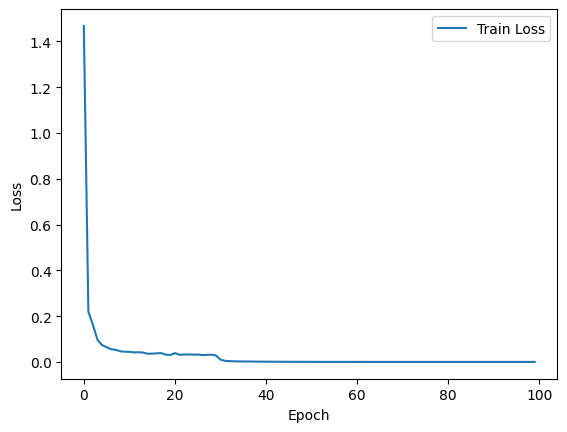

In [ ]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, (original_labels, aux_labels) in custom_trainloader:
        images = images.to(device)
        original_labels = original_labels.to(device)
        aux_labels = aux_labels.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = model(images)
        loss1 = criterion1(outputs1, original_labels)
        loss2 = criterion2(outputs2, aux_labels)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
correct1, correct2, total = 0, 0, 0

with torch.no_grad():
    for images, (original_labels, aux_labels) in custom_testloader:
        images = images.to(device)
        original_labels = original_labels.to(device)
        aux_labels = aux_labels.to(device)

        outputs1, outputs2 = model(images)
        _, predicted1 = torch.max(outputs1, 1)
        _, predicted2 = torch.max(outputs2, 1)
        total += original_labels.size(0)
        correct1 += (predicted1 == original_labels).sum().item()
        correct2 += (predicted2 == aux_labels).sum().item()

accuracy1 = 100 * correct1 / total
accuracy2 = 100 * correct2 / total
print(f"Accuracy on MNIST test set: {accuracy1:.2f}%")
print(f"Accuracy on auxiliary test set: {accuracy2:.2f}%")

Accuracy on MNIST test set: 99.53%
Accuracy on auxiliary test set: 99.80%


In [ ]:
image, label = custom_testset[0]
image = image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output1, output2 = model(image)
    _, predicted1 = torch.max(output1, 1)
    _, predicted2 = torch.max(output2, 1)
    predicted = (predicted1, predicted2)

(tensor([7], device='cuda:0'), tensor([1], device='cuda:0'))


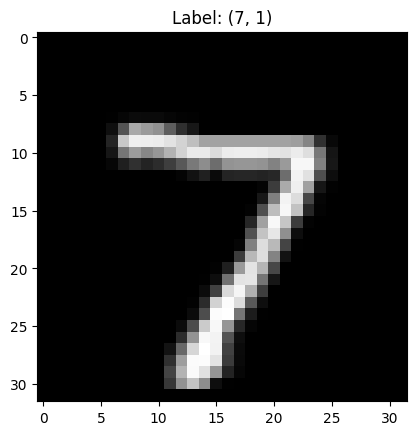

In [ ]:
print(predicted)

image = image.squeeze().to('cpu')

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [ ]:
# Lưu mô hình
torch.save(model.state_dict(), "resnet34_mnist.pth")